In this notebook we explain how do we implement the Displaced Diffusion model, here are the steps

1. Retrieve market implied volatility
2. Find sigma and beta so that volatility difference is minimized
3. Use sigma and beta from #2 to calculate dd pricing
4. Retrieve impl vol for dd pricing results
5. Plot implied vols for market and DD

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

In [2]:
#disp diffusion
def displaced_diffusion_call(S,K,r,sigma,T,beta):
    '''
    Returns price of a call option using the displaced diffusion method
    
        Parameters:
            S       : Underlying asset (i.e. Stock) price
            K       : Strike price
            r       : risk free rate (in decimals, not percentage, usually per annum)
            sigma   : volatility
            T       : time period (usually per annum)
            beta    : displace diffusion parameter
        
        Returns :
            call option price
    '''
    #params seem shared for call and put, possible to create
    F = S * np.exp(r*T)
    F_b = F / beta
    sigma_b = sigma * beta
    K_b = K + (( 1.0 - beta )* F / beta) 

    d1 = (np.log(F_b / K_b) + (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    d2 = (np.log(F_b / K_b) - (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    return np.exp(-r * T) * (F_b * norm.cdf(d1) - K_b * norm.cdf(d2))

def displaced_diffusion_put(S,K,r,sigma,T,beta):
    '''
    Returns price of a put option using the displaced diffusion method
    
        Parameters:
            S       : Underlying asset (i.e. Stock) price
            K       : Strike price
            r       : risk free rate (in decimals, not percentage, usually per annum)
            sigma   : volatility
            T       : time period (usually per annum)
            beta    : displace diffusion parameter
        
        Returns :
            put option price
    '''
    F = S * np.exp(r*T)
    F_b = F / beta
    sigma_b = sigma * beta
    K_b = K + (( 1.0 - beta )* F / beta) 
    d1 = (np.log(F_b / K_b) + (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    d2 = (np.log(F_b / K_b) - (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    return np.exp(-r * T) * (K_b * norm.cdf(-d2) - F_b * norm.cdf(-d1))

In [3]:
#implied volatility reporting
def implied_volatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            #print('call impl')
            impliedVol = brentq(lambda x: price -
                                black_scholes_call(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            #print('put impl')
            impliedVol = brentq(lambda x: price -
                                black_scholes_put(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception as e:
        #print(e)
        impliedVol = np.nan

    return impliedVol

def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def black_scholes_put(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [4]:
#Read SPX data
filename = 'SPX_options'
df = pd.read_csv(f'{filename}.csv')
df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['exdate'] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['years_to_expiry'] = df['days_to_expiry']/365

#setup rates calculator
rates_df = pd.read_csv('zero_rates_20201201.csv')
rate_interpolate = interp1d(rates_df['days'], rates_df['rate'])
df['rates'] = rate_interpolate(df['days_to_expiry']) / 100.0 #make it in fractions so i dont forget
try:
    if filename.lower() == 'spy_options':
        S = 366.02
    elif filename.lower() == 'spx_options':
        S = 3662.45
    else:
        raise NameError('unknown input file')
except Exception as e:
    print(e)

#df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,mid,strike,payoff,days_to_expiry,years_to_expiry,rates
0,2020-12-01,2020-12-18,C,100000,3547.6,3570.5,E,3559.05,100.0,call,17,0.046575,0.001255
1,2020-12-01,2020-12-18,C,200000,3447.6,3470.5,E,3459.05,200.0,call,17,0.046575,0.001255
2,2020-12-01,2020-12-18,C,300000,3347.7,3370.6,E,3359.15,300.0,call,17,0.046575,0.001255
3,2020-12-01,2020-12-18,C,400000,3247.7,3270.6,E,3259.15,400.0,call,17,0.046575,0.001255
4,2020-12-01,2020-12-18,C,500000,3147.7,3170.6,E,3159.15,500.0,call,17,0.046575,0.001255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,2020-12-01,2021-02-19,P,5000000,1333.1,1350.5,E,1341.80,5000.0,put,80,0.219178,0.002206
2068,2020-12-01,2021-02-19,P,5100000,1431.8,1454.7,E,1443.25,5100.0,put,80,0.219178,0.002206
2069,2020-12-01,2021-02-19,P,5200000,1531.7,1554.6,E,1543.15,5200.0,put,80,0.219178,0.002206
2070,2020-12-01,2021-02-19,P,5300000,1631.5,1654.4,E,1642.95,5300.0,put,80,0.219178,0.002206


In [5]:
#ADD IMPLIED MARKET VOLATILITY
df['vols'] = df.apply(lambda x: implied_volatility(S, x['strike'], x['rates'], x['mid'], x['years_to_expiry'], x['payoff']),axis=1)
#df.dropna(inplace=True)
#df
#implied_volatility(S,100.0,0.001255,0.025,0.046575,'put')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,mid,strike,payoff,days_to_expiry,years_to_expiry,rates,vols
0,2020-12-01,2020-12-18,C,100000,3547.6,3570.5,E,3559.05,100.0,call,17,0.046575,0.001255,NaN
1,2020-12-01,2020-12-18,C,200000,3447.6,3470.5,E,3459.05,200.0,call,17,0.046575,0.001255,NaN
2,2020-12-01,2020-12-18,C,300000,3347.7,3370.6,E,3359.15,300.0,call,17,0.046575,0.001255,NaN
3,2020-12-01,2020-12-18,C,400000,3247.7,3270.6,E,3259.15,400.0,call,17,0.046575,0.001255,NaN
4,2020-12-01,2020-12-18,C,500000,3147.7,3170.6,E,3159.15,500.0,call,17,0.046575,0.001255,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,2020-12-01,2021-02-19,P,5000000,1333.1,1350.5,E,1341.80,5000.0,put,80,0.219178,0.002206,0.341058
2068,2020-12-01,2021-02-19,P,5100000,1431.8,1454.7,E,1443.25,5100.0,put,80,0.219178,0.002206,0.370768
2069,2020-12-01,2021-02-19,P,5200000,1531.7,1554.6,E,1543.15,5200.0,put,80,0.219178,0.002206,0.387810
2070,2020-12-01,2021-02-19,P,5300000,1631.5,1654.4,E,1642.95,5300.0,put,80,0.219178,0.002206,0.403519


In [6]:
#create market DF for each timestamp
days_to_expiry  = sorted(df['days_to_expiry'].unique())
summary_df = pd.DataFrame({'strike': df['strike'].unique() })


In [7]:
for days in days_to_expiry:
    day_df  = df[df['days_to_expiry'] == days]
    call_df = day_df[day_df['payoff'] == 'call']
    put_df  = day_df[day_df['payoff'] == 'put']
    strikes = sorted(day_df['strike'].unique())
    impliedvols = []
    from_call_or_put = []
    mid = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
            mid.append(call_df[call_df['strike'] == K]['mid'].values[0])
            from_call_or_put.append('call')
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
            mid.append(put_df[put_df['strike'] == K]['mid'].values[0])
            from_call_or_put.append('put')
# populate "df" with the dataframe containing strikes and market implied volatilities
    mykey = 'impliedvol' + str(days)
    day_market_df = pd.DataFrame({'strike': strikes, mykey : impliedvols})

    summary_df = pd.merge(summary_df, day_market_df, how="outer", on='strike')

In [8]:
#pd.set_option('display.max_rows', 500) 
#summary_df

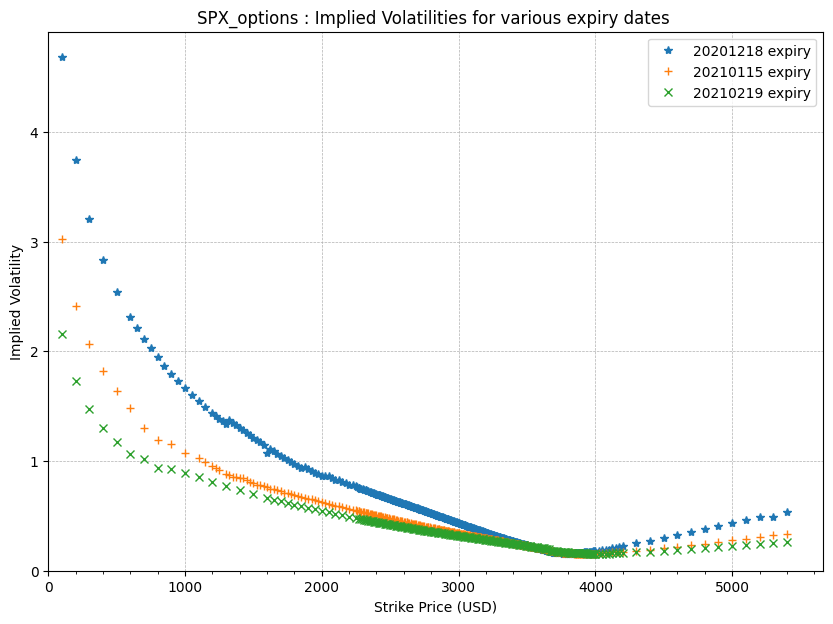

In [9]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f0, ax0 = plt.subplots(1)
f0.set_figheight(7)
f0.set_figwidth(10)
ax0.plot(summary_df['strike'],summary_df['impliedvol17'],'*',label = '20201218 expiry')
ax0.plot(summary_df['strike'],summary_df['impliedvol45'],'+',label = '20210115 expiry')
ax0.plot(summary_df['strike'],summary_df['impliedvol80'],'x',label = '20210219 expiry')
ax0.xaxis.set_major_locator(ticker.AutoLocator())
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax0.grid(linestyle = '--', linewidth = 0.5)
ax0.set_ylim(ymin=0)
ax0.set_xlim(xmin=0)
ax0.legend()
ax0.set_title(f'{filename} : Implied Volatilities for various expiry dates ')
ax0.set_xlabel('Strike Price (USD)')
ax0.set_ylabel('Implied Volatility')
plt.show(f0)
f0.savefig(f'{filename}_vol_all.jpeg')

In [10]:
#get atm implied vols, this is an approximation but good enough
atm_vols = []
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    print(adjusted_summary_df)
    atm_vols.append(np.interp(S,adjusted_summary_df.iloc[:, 0],adjusted_summary_df.iloc[:, 1]))
#atm_vols

     strike  impliedvol17
0     100.0      4.685324
1     200.0      3.741195
2     300.0      3.204791
3     400.0      2.830325
4     500.0      2.542973
..      ...           ...
406  5000.0      0.436196
407  5100.0      0.461523
408  5200.0      0.486234
409  5300.0      0.486495
410  5400.0      0.533932

[411 rows x 2 columns]
     strike  impliedvol45
0     100.0      3.020479
1     200.0      2.408988
2     300.0      2.062602
3     400.0      1.821174
4     500.0      1.636102
..      ...           ...
406  5000.0      0.276282
407  5100.0      0.292255
408  5200.0      0.307836
409  5300.0      0.323046
410  5400.0      0.337903

[369 rows x 2 columns]
     strike  impliedvol80
0     100.0      2.160100
1     200.0      1.724868
2     300.0      1.477592
3     400.0      1.304969
4     500.0      1.172504
..      ...           ...
406  5000.0      0.224559
407  5100.0      0.234641
408  5200.0      0.243829
409  5300.0      0.255771
410  5400.0      0.263514

[256 rows x 2 c

In [11]:
for i,days in enumerate(days_to_expiry):
    trial_beta = 0.5
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    
    #params
    sigma = atm_vols[i]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {rate} {T}')

    #marketvols
    strikes = adjusted_summary_df.iloc[:,0].to_numpy()
    marketvols = adjusted_summary_df.iloc[:,1].to_numpy()
    adjusted_summary_list = list(zip(strikes, marketvols ))

    dd_price = []
    dd_impl_vol = []

    for strike, vol in adjusted_summary_list:
        if strike > S:
            dd_price_call   = displaced_diffusion_call(S,strike,rate,sigma,T,trial_beta)
            dd_price.append(dd_price_call)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_call,T,'call'))
        else:
            dd_price_put    = displaced_diffusion_put(S,strike,rate,sigma,T,trial_beta)
            dd_price.append(dd_price_put)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_put,T,'put'))

    adjusted_summary_df['dd_price'] = dd_price
    adjusted_summary_df['dd_impl_vol'] = dd_impl_vol

    #print(adjusted_summary_df)


3662.45 3662.664084743022 0.17448532472572187 0.0012550044444444445 0.04657534246575343
3662.45 3663.3762493669747 0.1849096526276905 0.0020510755555555554 0.1232876712328767
3662.45 3664.221472703759 0.19374721854522414 0.0022062799999999997 0.2191780821917808


In [12]:
def dd_calibration(x, S,strikes,rate,sigma,T, market_vols):
    err = 0.0 
    imp_vol_list = []
    for strike in strikes:
        if strike > S:
            dd_price_call   = displaced_diffusion_call(S,strike,rate,sigma,T,x[0])
            imp_vol  = implied_volatility(S,strike,rate,dd_price_call,T,'call')
        else:
            dd_price_put    = displaced_diffusion_put(S,strike,rate,sigma,T,x[0])
            imp_vol  =  implied_volatility(S,strike,rate,dd_price_put,T,'put')
        imp_vol_list.append(imp_vol)
    zipped_vols = list(zip(market_vols, imp_vol_list))
    #print(zipped_vols)
    for market_vol, dd_vol in zipped_vols:
        err += (market_vol - dd_vol) ** 2
    return err

In [13]:
sigma_beta_pair = []
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    
    #params
    sigma = atm_vols[i]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {rate} {T}')

    strikes = adjusted_summary_df.iloc[:,0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:,1].to_numpy()

    initial = 0.5
    result = least_squares(dd_calibration ,initial, args = (S,strikes,rate,sigma,T,market_vols), bounds=(0.0,1))
    beta = result.x[0]
    sigma_beta_pair.append([sigma,beta])
    print(f'sigma = {sigma} ;  beta ={beta}')
        

3662.45 3662.664084743022 0.17448532472572187 0.0012550044444444445 0.04657534246575343
[(4.6853242566014695, 0.4717127408230641), (3.741195366679193, 0.39647765419176606), (3.204790943301636, 0.35536384465645093), (2.8303249198950775, 0.32779218845556396), (2.5429725280769087, 0.30743677479176673), (2.3099940196122635, 0.29152885222125435), (2.208179398612331, 0.28476086704254544), (2.114149464808785, 0.27861578074402665), (2.02680190513828, 0.27300145215455845), (1.9452516176565848, 0.2678441631735739), (1.8687772819967023, 0.26308406725294137), (1.796783383154897, 0.2586719550296096), (1.7287726228650178, 0.25456690583057356), (1.6643254887572205, 0.25073454977833937), (1.6030848647035196, 0.24714575996431676), (1.5447442612104727, 0.2437756533848644), (1.489038690841502, 0.24060281741835926), (1.4357375066631763, 0.23760870358334776), (1.4099244490799732, 0.23617353393656323), (1.3846387182603603, 0.23477714715006132), (1.3598587959419224, 0.2334178320631588), (1.3355644342899304, 

In [14]:
#get prices for given beta
sigma_beta_pair

[[0.17448532472572187, 2.8614115061353138e-06],
 [0.1849096526276905, 4.6775165629062157e-07],
 [0.19374721854522414, 2.8464102518092144e-11]]

In [15]:
#displaced_diffusion_call(3662.664084743022 ,3600.0 ,0.0012550044444444445 ,0.17448532472572187,0.04657534246575343,1.3163138355318966e-06)
#displaced_diffusion_put(3662.664084743022 ,3600.0 ,0.0012550044444444445 ,0.17448532472572187,0.04657534246575343,1.3163138355318966e-06)

In [16]:
dd_summary_df = pd.DataFrame({'strike': df['strike'].unique() })
#dd_summary_df

In [17]:
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    #params
    sigma = sigma_beta_pair[i][0]
    beta = sigma_beta_pair[i][1]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {beta} {rate} {T}')
    strikes = adjusted_summary_df.iloc[:,0].to_numpy()

    dd_price = []
    dd_impl_vol = []

    for strike in strikes :
        if strike > S :
            dd_price_call   = displaced_diffusion_call(F,strike,rate,sigma,T,beta)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_call,T,'call'))
        else:
            dd_price_put    = displaced_diffusion_put(F,strike,rate,sigma,T,beta)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_put,T,'put'))

    mykey = 'dd_impliedvol' + str(days)
    day_dd_imp_df = pd.DataFrame({'strike': strikes, mykey : dd_impl_vol})

    dd_summary_df = pd.merge(dd_summary_df, day_dd_imp_df, how="outer", on='strike')
    

3662.45 3662.664084743022 0.17448532472572187 2.8614115061353138e-06 0.0012550044444444445 0.04657534246575343
3662.45 3663.3762493669747 0.1849096526276905 4.6775165629062157e-07 0.0020510755555555554 0.1232876712328767
3662.45 3664.221472703759 0.19374721854522414 2.8464102518092144e-11 0.0022062799999999997 0.2191780821917808


In [18]:
dd_summary_df

,strike,dd_impliedvol17,dd_impliedvol45,dd_impliedvol80
0,100.0,0.646392,0.686042,0.720431
1,200.0,0.536921,0.569616,0.598012
2,300.0,0.475737,0.504599,0.529758
3,400.0,0.433915,0.460178,0.483077
4,500.0,0.402509,0.426830,0.447937
...,...,...,...,...
406,5000.0,0.148776,0.157806,0.165508
407,5100.0,0.147231,0.156161,0.163798
408,5200.0,0.145727,0.154561,0.162105
409,5300.0,0.144262,0.153003,0.160494


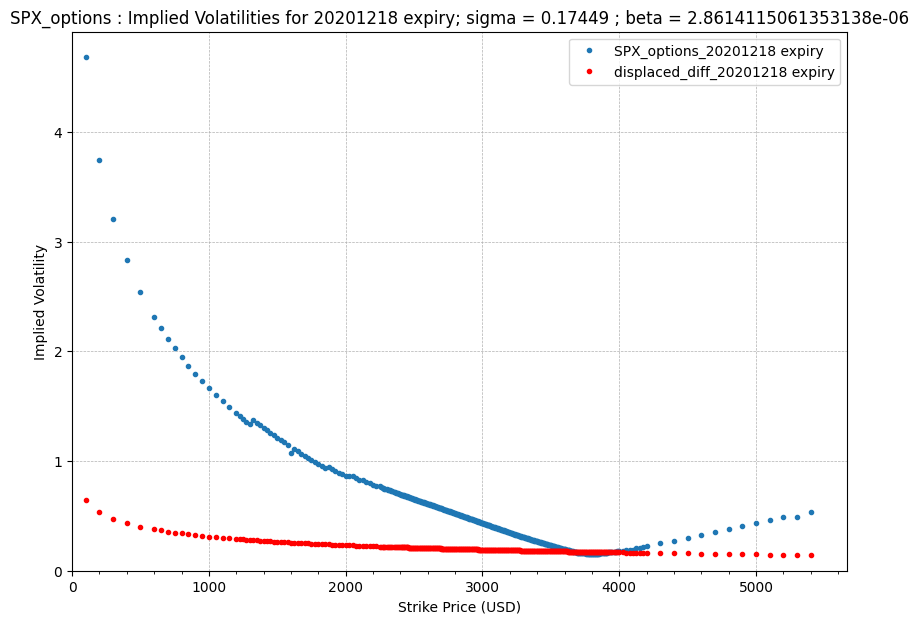

In [19]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f1, ax1 = plt.subplots(1)
f1.set_figheight(7)
f1.set_figwidth(10)
ax1.plot(summary_df['strike'],summary_df['impliedvol17'],'.',label = f'{filename}_20201218 expiry')
ax1.plot(summary_df['strike'],dd_summary_df['dd_impliedvol17'],'.',color='red',label = 'displaced_diff_20201218 expiry')
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.grid(linestyle = '--', linewidth = 0.5)
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax1.legend()
ax1.set_title(f'{filename} : Implied Volatilities for 20201218 expiry; sigma = {sigma_beta_pair[0][0]:.5f} ; beta = {sigma_beta_pair[0][1]}')
ax1.set_xlabel('Strike Price (USD)')
ax1.set_ylabel('Implied Volatility')
plt.show(f1)
f1.savefig(f'{filename}_20201218_expiry_vol.jpg')

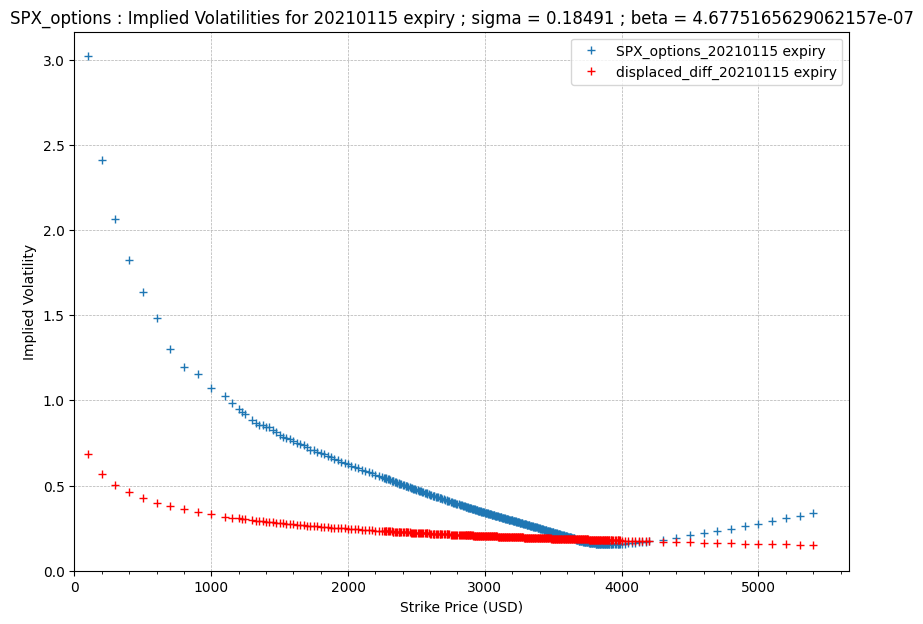

In [20]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f2, ax2 = plt.subplots(1)
f2.set_figheight(7)
f2.set_figwidth(10)
ax2.plot(summary_df['strike'],summary_df['impliedvol45'],'+',label = f'{filename}_20210115 expiry')
ax2.plot(summary_df['strike'],dd_summary_df['dd_impliedvol45'],'+',color='red',label = 'displaced_diff_20210115 expiry')
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.grid(linestyle = '--', linewidth = 0.5)
ax2.set_ylim(ymin=0)
ax2.set_xlim(xmin=0)
ax2.legend()
ax2.set_title(f'{filename} : Implied Volatilities for 20210115 expiry ; sigma = {sigma_beta_pair[1][0]:.5f} ; beta = {sigma_beta_pair[1][1]}')
ax2.set_xlabel('Strike Price (USD)')
ax2.set_ylabel('Implied Volatility')
plt.show(f2)
f2.savefig(f'{filename}_20210115_expiry_vol.jpg')

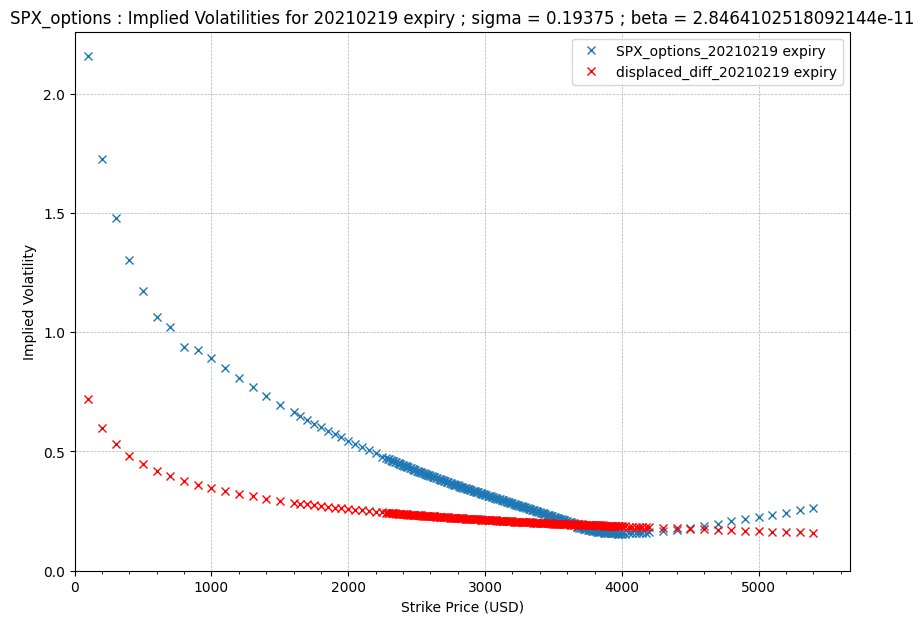

In [21]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f3, ax3 = plt.subplots(1)
f3.set_figheight(7)
f3.set_figwidth(10)
ax3.plot(summary_df['strike'],summary_df['impliedvol80'],'x',label = f'{filename}_20210219 expiry')
ax3.plot(summary_df['strike'],dd_summary_df['dd_impliedvol80'],'x',color='red',label = 'displaced_diff_20210219 expiry')
ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.grid(linestyle = '--', linewidth = 0.5)
ax3.set_ylim(ymin=0)
ax3.set_xlim(xmin=0)
ax3.legend()
ax3.set_title(f'{filename} : Implied Volatilities for 20210219 expiry ; sigma = {sigma_beta_pair[2][0]:.5f} ; beta = {sigma_beta_pair[2][1]}')
ax3.set_xlabel('Strike Price (USD)')
ax3.set_ylabel('Implied Volatility')
plt.show(f3)
f3.savefig(f'{filename}_20210119_expiry_vol.jpg')